# TASK 2.2: Tracking with a Kalman Filter

In [1]:
from __future__ import print_function
from skimage import io
from tqdm import tqdm
from sort import *
from IPython import display as dp
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pickle as pkl
import os
import time
import cv2
plt.style.use("default")
%matplotlib inline

First we load all the data

In [2]:
# Detection to DataFrame
def get_detection_dataframe(detections):
    bboxes = []
    bsizes = []
    bdetections = []
    tracks = list(range(0, len(detections)))
    
    colours = []
    for i in range(len(detections)):
        colours.append(tuple(np.random.choice(range(256), size=3).astype('int')))
    
    for detection in detections:
        bbox = np.array(detection.getBBox()).astype('int')
        bboxes.append(bbox)

        bsize = int(detection.areaOfRec())
        bsizes.append(bsize)

        bdetections.append(detection)

    detec = {
        'track': tracks,
        'detection': bdetections,
        'bbox': bboxes,
        'size': bsizes,
        'colour': colours,
    }
    detections_pd = pd.DataFrame(detec)
    detections_pd = detections_pd.sort_values(by=['size'], ascending=False)
    detections_pd = detections_pd.reset_index(drop=True)
    
    return detections_pd

In [3]:
# Load paths
file_path = 'detection_pkls/retinanet_101_detections.pkl'
data_path = '../datasets/AICity_data/train/S03/c010/'
video_path = '../datasets/AICity_data/train/S03/c010/vdo.avi'

# Load detections
with open(file_path , 'rb') as f:
    all_detections = pkl.load(f)

get_detection_dataframe(all_detections[str(0)]).sort_values("track")

,track,detection,bbox,size,colour
0,0,"Frame 0, TL [1284.8372802734375,362.1326904296...","[1284, 362, 1520, 539]",41907,"(172, 47, 117)"
2,1,"Frame 0, TL [564.6638793945312,96.273307800292...","[564, 96, 658, 168]",6779,"(192, 67, 251)"
4,2,"Frame 0, TL [928.7540283203125,78.073799133300...","[928, 78, 1014, 145]",5791,"(195, 103, 9)"
11,3,"Frame 0, TL [885.072265625,94.19532012939453],...","[885, 94, 935, 141]",2404,"(211, 21, 242)"
13,4,"Frame 0, TL [908.677734375,92.77952575683594],...","[908, 92, 944, 141]",1736,"(36, 87, 70)"
9,5,"Frame 0, TL [579.739501953125,74.2380752563476...","[579, 74, 658, 110]",2870,"(216, 88, 140)"
1,6,"Frame 0, TL [542.8624877929688,68.340904235839...","[542, 68, 631, 159]",8089,"(58, 193, 230)"
14,7,"Frame 0, TL [874.1964721679688,99.487159729003...","[874, 99, 910, 142]",1533,"(39, 87, 174)"
6,8,"Frame 0, TL [895.2154541015625,88.084892272949...","[895, 88, 961, 141]",3582,"(88, 81, 165)"
7,9,"Frame 0, TL [1178.972412109375,103.75167846679...","[1178, 103, 1228, 164]",3049,"(25, 77, 72)"


## Sort Kalman Filter Model for tracking

We use the Sort Kalman filter and save the generated bboxes

In [13]:
# Load video frames
vidcap = cv2.VideoCapture(video_path)
num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
total_time = 0
results = {}

mot_tracker = Sort(max_age=1, min_hits=3, iou_threshold=0.7) 

# Iterate Frames
for frame in tqdm(range(num_frames), desc = "Tracking objects each frame..."):
    dets = []
    colors = []

    _, im = vidcap.read() # Read frame
    detections = get_detection_dataframe(all_detections[str(frame)]).sort_values("track") # Load detections

    for (track_id, det, bbox, size, colour) in detections.itertuples(index=False): # Iter All Detections
        bbox = np.array(bbox) # To np.array
        colour = [c/255 for c in colour] # Normalize colour values
        dets.append(np.array(bbox))
        colors.append(colour)


    start_time = time.time()
    trackers = mot_tracker.update(np.array(dets))
    cycle_time = time.time() - start_time
    total_time += cycle_time


    for d in trackers:
        d = d.astype(np.int32)
        if frame not in results:
            results[frame] = {d[4] % 21: {"bbox": [d[0], d[1], d[2], d[3]]}}
        else:
            results[frame][d[4] % 21] = {"bbox": [d[0], d[1], d[2], d[3]]}

pkl.dump(results, open("sort_bbox.pkl", "wb"))

Tracking objects each frame...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2141/2141 [00:25<00:00, 84.20it/s]


Now let's plot the results

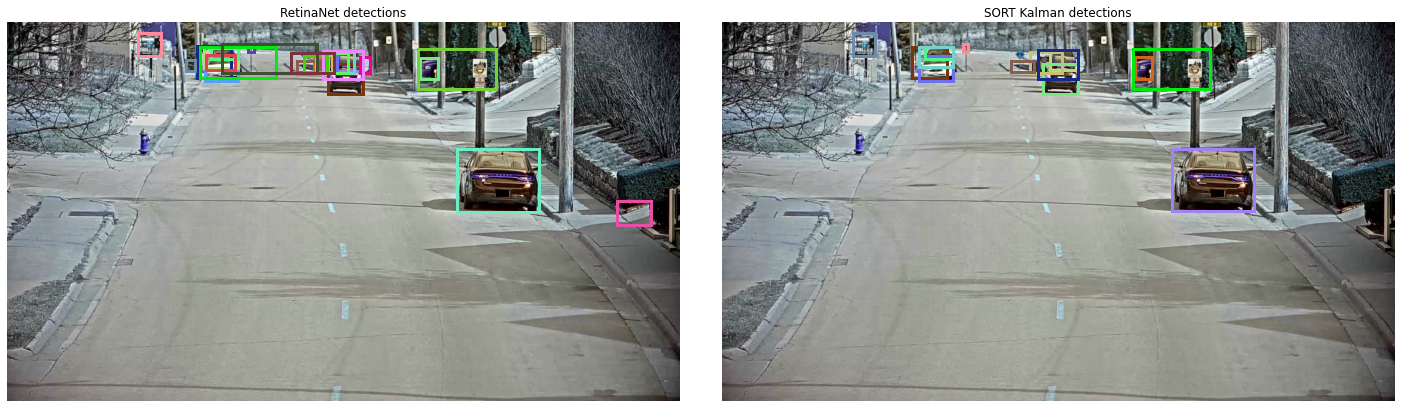

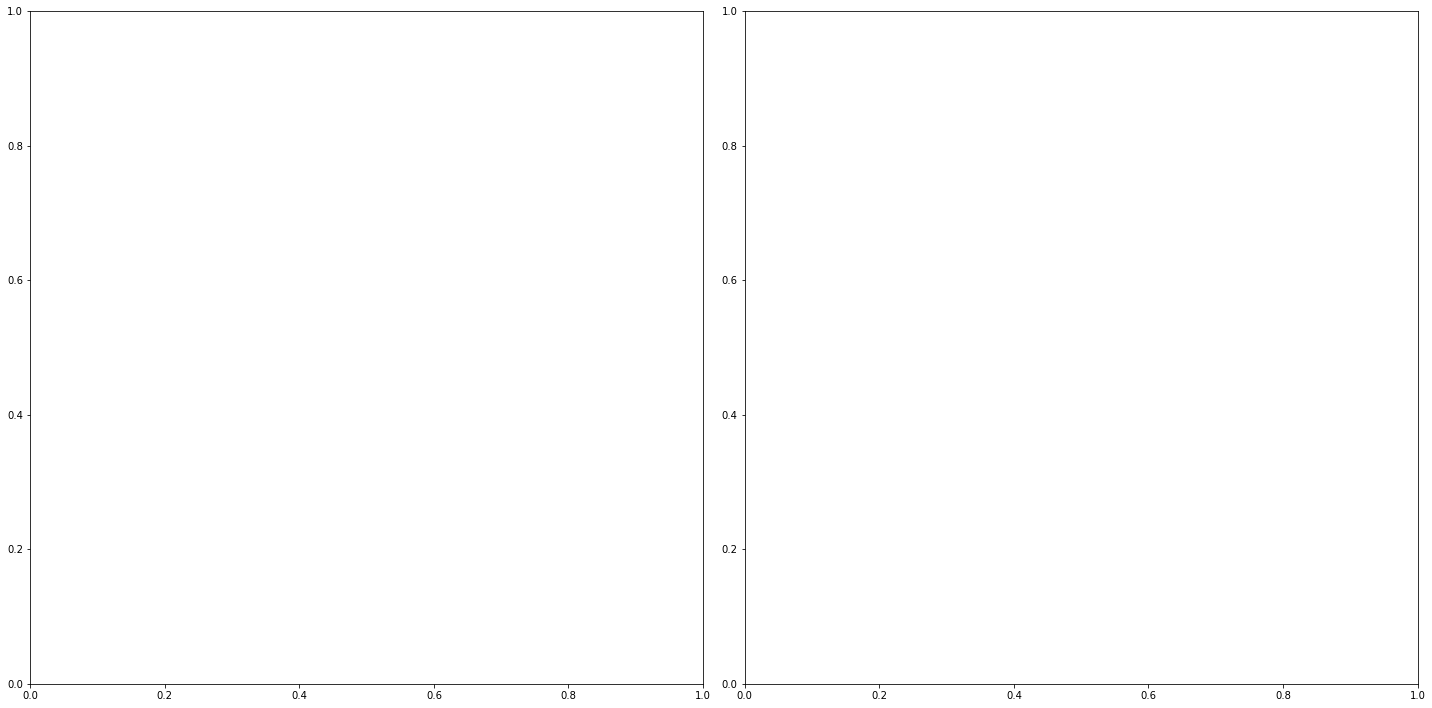

In [36]:
# Load video frames
vidcap = cv2.VideoCapture(video_path)
num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
results_kalman = pkl.load(open("sort_bbox.pkl", "rb"))

plt.ion() # for iterative display
fig, ax = plt.subplots(1, 2,figsize=(20,20))
plt.tight_layout(rect=[0, 0, 1, 0.95]) 

for frame in range(num_frames):
    _, im = vidcap.read() # Read frame
    detections = get_detection_dataframe(all_detections[str(frame)]).sort_values("track") # Load detections
    #fig.suptitle('Frame #{}'.format(frame))
    
    ax[0].imshow(im)
    ax[0].axis('off')
    ax[0].set_title('RetinaNet detections')
    
    ax[1].imshow(im)
    ax[1].axis('off')
    ax[1].set_title('SORT Kalman detections')
    
    for (track_id, det, bbox, size, colour) in detections.itertuples(index=False):
        colour = [c/255 for c in colour]
        
        coords_retina = (bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1]
        ax[0].add_patch(plt.Rectangle(*coords_retina,fill=False,edgecolor=colour,lw=3))
        
        try:
            kalman_bbox = results_kalman[frame][track_id]["bbox"]
            coords_kalman = (kalman_bbox[0], kalman_bbox[1]), kalman_bbox[2]-kalman_bbox[0], kalman_bbox[3]-kalman_bbox[1]

            ax[1].add_patch(plt.Rectangle(*coords_kalman,fill=False,edgecolor=colour,lw=3))
        except:
            pass
    
    
    plt.savefig('kalman_filter_frames/frame{}.png'.format(frame))
    dp.clear_output(wait=True)
    dp.display(plt.gcf())
    time.sleep(0.000001)
    ax[0].cla()
    ax[1].cla()